# Teste de Hipóteses

In [1]:
import pandas as pd #pacote para manipulação de dados
import matplotlib.pyplot as plt # pacote para criar gráficos
import scipy.stats as spy
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8) # define o tamanho padrão dos gráficos criados
sns.set()
plt.style.use('ggplot')


### Importação dos Dados

In [2]:
path = r"D:\UFPR\2º Semestre 2021\Estatística Econômica e Introdução à Econometria\1. Relatório Enade\2018\3.DADOS\microdados_enade_2018.txt"
enade = pd.read_table(path, sep=';', decimal=',')

In [3]:
selecionado = enade.filter(['CO_GRUPO','CO_MODALIDADE','NT_GER'])

In [4]:
economia_enade = selecionado[enade.CO_GRUPO == 13].dropna()

In [5]:
selecionado['NT_GER'].dropna().mean()

41.79012335796744

In [6]:
modalidade_dict = {
    1:'Presencial',
    2:'Ensino à Distância'
}

In [7]:
economia_enade['CO_MODALIDADE'] = [modalidade_dict[resp] for resp in economia_enade.CO_MODALIDADE]

In [8]:
economia_enade

,CO_GRUPO,CO_MODALIDADE,NT_GER
160,13,Presencial,24.9
161,13,Presencial,25.6
162,13,Presencial,48.7
163,13,Presencial,35.7
164,13,Presencial,33.9
...,...,...,...
546659,13,Presencial,40.9
547633,13,Presencial,32.2
547634,13,Presencial,27.8
547635,13,Presencial,30.2


In [9]:
economia_presencial = economia_enade[economia_enade.CO_MODALIDADE == 'Presencial']['NT_GER']

In [10]:
economia_ead = economia_enade[economia_enade.CO_MODALIDADE == 'Ensino à Distância']['NT_GER']

In [11]:
economia_presencial.mean() #média do presencial

38.398858647936784

In [12]:
economia_presencial.median() #mediana do presencial

37.2

In [13]:
economia_presencial.std() #desvio padrão EAD

13.127434854617633

In [14]:
len(economia_presencial) #quantidade de alunos  do presencial

7973

In [15]:
economia_ead.mean() #média EAD

38.282999999999994

In [16]:
economia_ead.median() #mediana EAD

35.7

In [17]:
economia_ead.std() #desvio padrão EAD

14.005886605137126

In [18]:
len(economia_ead)

100

### Testes de Normalidade

Normal Test (D’Agostino and Pearson’s)


In [19]:
alpha = 0.05
k2, p = spy.normaltest(economia_enade['NT_GER'])

#Hipotese nula: Os dados seguem distribuição normal
#Hipotese alternativa: Os dados não seguem distribuição normal

if p < alpha:
    print("A Hipótese Nula pode ser rejeitada")
else:
    print("A hipótese nula não pode ser rejeitada")


A Hipótese Nula pode ser rejeitada


Shapiro-Wilk (Adequado para amostrar pequenas)

In [20]:
stat, p = spy.shapiro(economia_enade['NT_GER'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)


C:\python3.10\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [21]:
spy.anderson(economia_ead)

AndersonResult(statistic=0.44641009922349895, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Anderson-Darling Test

In [22]:
result = spy.anderson(economia_presencial)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    

Statistic: 23.568
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


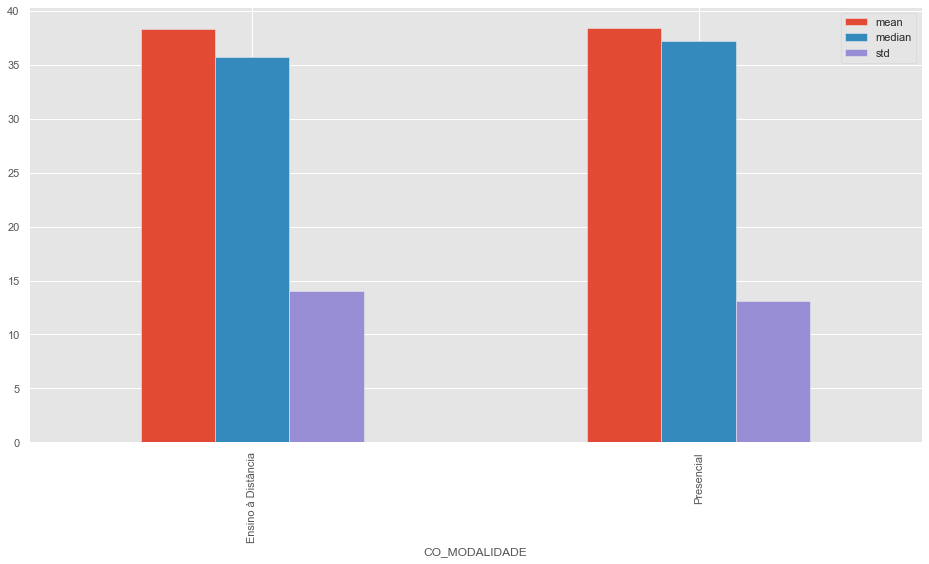

In [23]:
economia_enade.groupby('CO_MODALIDADE')['NT_GER'].agg(['mean','median','std']).plot(kind='bar');

### Bootstrapping

A função abaixo gera uma permutação dos dados(mistura ead e presencial)

In [24]:
def permuted_iid_samples(data1, data2):
    data = np.concatenate((data1, data2))

    permuted_data = np.random.permutation(data)

    permuted_sample_1 = permuted_data[:len(data1)]

    permuted_sample_2 = permuted_data[len(data1):]

    return permuted_sample_1, permuted_sample_2

In [25]:
def sample_replicates(data_1, data_2, function, size=1):

    permuted_replicates = np.empty(size)

    for i in range(size):
        perm_sample_1, perm_sample_2 = permuted_iid_samples(data_1, data_2)
        permuted_replicates[i] = function(perm_sample_1, perm_sample_2)

    return permuted_replicates

In [26]:
def means_diff(data_1, data_2):

    diff = np.mean(data_1) - np.mean(data_2)

    return diff

In [27]:
np.random.seed(13)
empirical_diff = round((np.mean(economia_presencial) - np.mean(economia_ead)), 2)
f'A diferença de média é : {empirical_diff}'

'A diferença de média é : 0.12'

O presencial tem uma média de 0.12 maior que o ead

In [28]:
sample_replicates(economia_presencial, economia_ead, means_diff, 10) #misturando os dados 10 vezes, aleatorioamente

array([ 0.16648576, -1.1842457 ,  1.46659012,  2.13689314,  2.72619278,
       -0.43192675, -2.01351787, -0.15246507, -1.24904841,  0.06118136])

In [29]:
replicates = sample_replicates(economia_presencial, economia_ead, means_diff, 10000)

In [30]:
p = np.sum(replicates >= empirical_diff) / len(replicates)

In [31]:
f'O p-valor para o teste estatístico de {empirical_diff:.2f} é {p:.3f}'

'O p-valor para o teste estatístico de 0.12 é 0.464'

Se a diferença de média 0.12 for verdadeira, ela precisa ocorrer várias vezes.  O p-valor é a probabilidade de ver essa diferença acontecer no mundo da hipótese nula

In [32]:
np.sum(replicates >= empirical_diff)

4637

In [33]:
confidence_interval = np.percentile(replicates, [2.5, 97.5])

C:\python3.10\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Diferença de Média (Nota)')

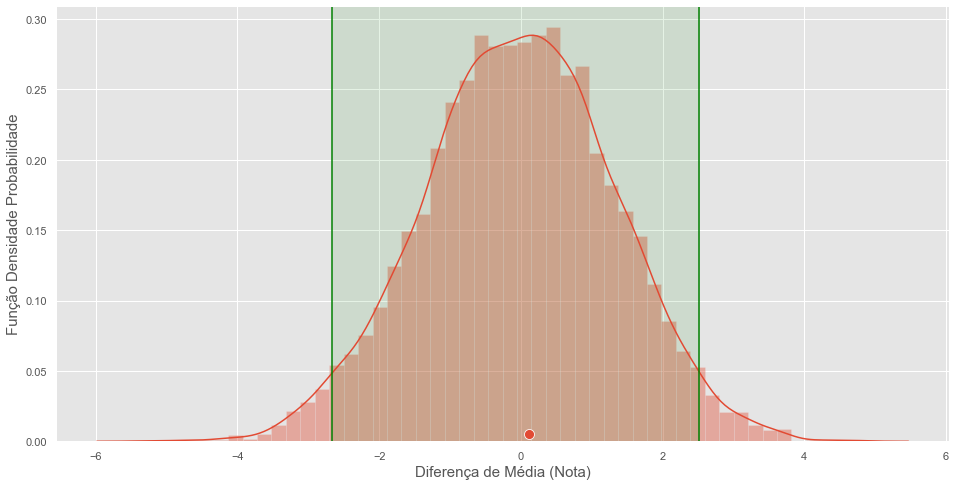

In [40]:
axs = sns.distplot(replicates)
axs.axvline(confidence_interval[0], color='green')
axs.axvline(confidence_interval[1], color='green')
axs.axvspan(confidence_interval[0], confidence_interval[1], color = 'green', alpha=0.1)
axs = sns.scatterplot(x = np.array([empirical_diff]), y=0.005, s=100)
axs.set_ylabel('Função Densidade Probabilidade', size=15)
axs.set_xlabel('Diferença de Média (Nota)', size=15)


Text(0.015, 0.5, '0.12')

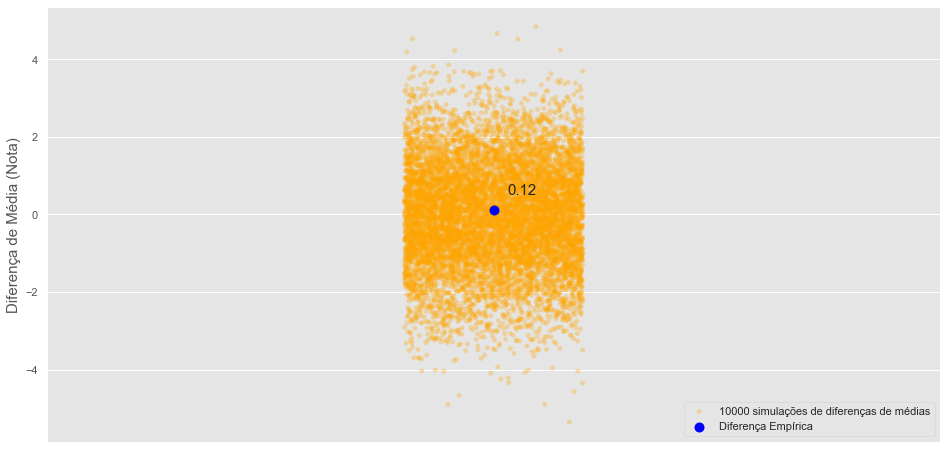

In [50]:
axs = sns.stripplot(y = replicates, alpha = 0.30, color='orange', label = '10000 simulações de diferenças de médias')
axs = sns.swarmplot( y = np.array([empirical_diff]), color='blue', size = 10, label = 'Diferença Empírica')
axs.legend(loc='lower right')
axs.set_ylabel('Diferença de Média (Nota)', size=15)
axs.annotate(str(empirical_diff),xy = (0.015,0.5), size=15)


É bem provável que a diferença de notas seja maior?

 a falha é considerar que as temperaturas anuais são independentes entre si, que é exatamente  como o procedimento do bootstrap atua. Por exemplo, a temperatura do ano atual não teria relação nenhuma com as temperaturas dos anos anteriores. Nesse caso, é provável que o teste de hipótese seja falho, pois ele não considerou a dependência que existe das series temporais das temperaturas dos anos subsequentes.

### Mann-Whitney

In [36]:
# perform mann whitney test
stat, p_value = spy.mannwhitneyu(economia_presencial, economia_ead)
print('Statistics=%.2f, p=%.2f' % (stat, p_value))
# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Statistics=402817.50, p=0.86
Do not Reject Null Hypothesis (No significant difference between two samples)


Text(0, 0.5, 'Nota Média')

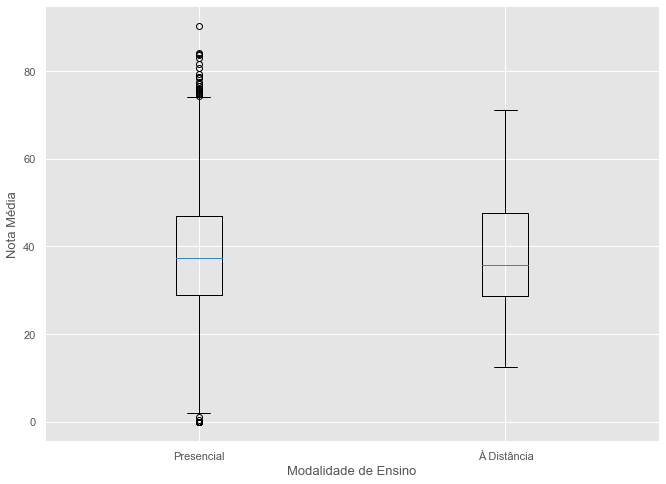

In [65]:
ax, fig = plt.subplots(figsize =(11, 8))
plt.boxplot((economia_presencial, economia_ead), vert=1);
plt.xticks([1, 2], ['Presencial', 'À Distância'])
plt.xlabel("Modalidade de Ensino",size=13)
plt.ylabel("Nota Média",size=13)


In [69]:
economia_ead.describe()

count    100.000000
mean      38.283000
std       14.005887
min       12.500000
25%       28.725000
50%       35.700000
75%       47.625000
max       71.100000
Name: NT_GER, dtype: float64

In [70]:
47-28.725

18.275